<a href="https://colab.research.google.com/github/guilhermedossantos/TCC_NN_SARIMA/blob/master/teste_airlines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
#### SETUP ####
# Keras
from keras.models import Sequential # modelo
from keras.layers import Dense, SimpleRNN, LSTM, Reshape,Dropout # camadas
from keras.callbacks import EarlyStopping # early stopping
from keras.optimizers import Adam

# scaler
from sklearn.preprocessing import MinMaxScaler

# Importação do arquivo 
from google.colab import files # upload de arquivos da máquina
import pandas_datareader as web # pacote bem interessante que pode valer a pena explorar (para importação de dados de diversar fontes)

# Gerais
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats # usado no qq-plot
import plotly.tools as tls # para tentativa de converter mpl to plotly

# Removendo warnings
import warnings
warnings.filterwarnings('ignore') # tem também a opção 'once' para mostrar apenas uma vez

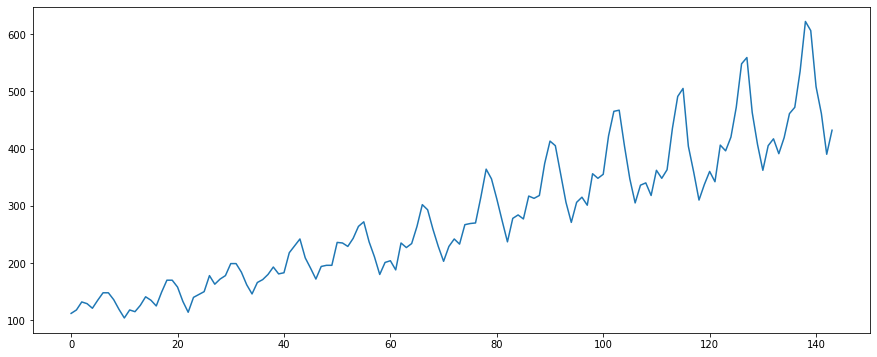

In [12]:
serie = pd.read_csv("https://raw.githubusercontent.com/harishkandan/Air-passengers-time-series-forecasting/master/AirPassengers.csv", index_col=0)
serie = serie
serie = np.array(serie)
#serie
plt.figure(figsize = (15,6))
#plt.plot(serie[1:] - serie[:(len(serie) - 1)])
plt.plot(serie)


In [13]:
serie_original = serie

scaler = MinMaxScaler(feature_range=(0,1))
serie = scaler.fit_transform(serie_original)

# Função que transforma a série em uma matriz com k colunas (entradas da rede)
def convert_to_matrix(data, step):
 X, Y =[], []
 for i in range(len(data)-step):
  d=i+step  
  X.append(data[i:d,])
  Y.append(data[d,])
 return np.array(X), np.array(Y)


k = 12
x, y = convert_to_matrix(serie,k)


In [14]:
x = x.reshape((-1,k,1))
treinox = x[0:(len(x) - 30)]
treinoy = y[0:(len(x) - 30)]
testex = x[(len(x) - 30):]
testey = y[(len(x) - 30):]

In [15]:
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape = (k,1)))#, return_sequences=True))
#model.add(Dropout(0.3)) #, return_sequences = True))
#model.add(LSTM(128, activation='sigmoid', input_shape = (k,1)))
#model.add(LSTM(128, activation='tanh', input_shape = (k,1)))
#model.add(Dense(25, activation = "sigmoid"))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['mape', 'mae', 'mse'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['mape', 'mae', 'mse'])
history = model.fit(treinox, treinoy, epochs=80, validation_data=(testex, testey), verbose = 1)

Train on 102 samples, validate on 30 samples
Epoch 1/80
102/102 [==============================] - 0s 4ms/step - loss: 0.0837 - mape: 85.3753 - mae: 0.2478 - mse: 0.0837 - val_loss: 0.2718 - val_mape: 75.6125 - val_mae: 0.5003 - val_mse: 0.2718
Epoch 2/80
102/102 [==============================] - 0s 698us/step - loss: 0.0508 - mape: 60.8028 - mae: 0.1856 - mse: 0.0508 - val_loss: 0.1680 - val_mape: 56.8675 - val_mae: 0.3834 - val_mse: 0.1680
Epoch 3/80
102/102 [==============================] - 0s 710us/step - loss: 0.0261 - mape: 46.8542 - mae: 0.1237 - mse: 0.0261 - val_loss: 0.0724 - val_mape: 31.8511 - val_mae: 0.2273 - val_mse: 0.0724
Epoch 4/80
102/102 [==============================] - 0s 631us/step - loss: 0.0102 - mape: 51.8138 - mae: 0.0756 - mse: 0.0102 - val_loss: 0.0201 - val_mape: 17.7409 - val_mae: 0.1152 - val_mse: 0.0201
Epoch 5/80
102/102 [==============================] - 0s 598us/step - loss: 0.0148 - mape: 84.3449 - mae: 0.1103 - mse: 0.0148 - val_loss: 0.0202 - v

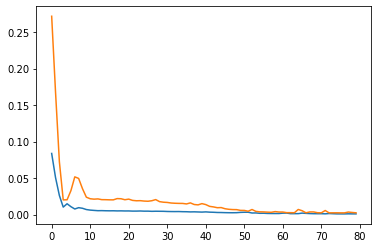

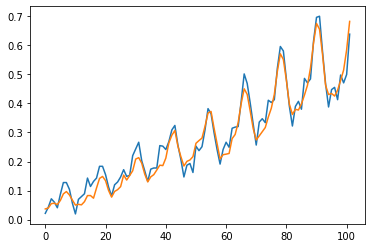

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.figure()
plt.plot(treinoy)
plt.plot(model.predict(treinox))

30/30 [==============================] - 0s 106us/step


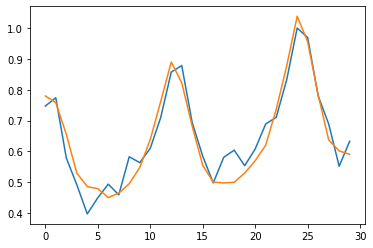

In [18]:
model.evaluate(testex, testey)

plt.plot(testey)
plt.plot(model.predict(testex))

In [19]:
preds = model.predict(testex)
preds_original = scaler.inverse_transform(preds)

y_original = scaler.inverse_transform(testey)

mape = np.mean(abs((y_original - preds_original)/abs(y_original))*100)
mae = np.mean(abs(y_original - preds_original))
mse = np.mean((y_original - preds_original)**2)


print("MAPE com prev. 1 passo a frente: {}%".format(round(mape,3)))
print("MSE com prev. 1 passo a frente: {}".format(round(mse)))
print("MAE com prev. 1 passo a frente: {}".format(round(mae,3)))
print("Vício: {}".format(np.mean(preds_original - y_original).round(3)))


MAPE com prev. 1 passo a frente: 5.046%
MSE com prev. 1 passo a frente: 640.0
MAE com prev. 1 passo a frente: 21.288
Vício: -2.347


MAPE: 6.39%
MAE: 26.224
MSE: 971.826
Vício: 3.236


Text(0.5, 0, 'h')

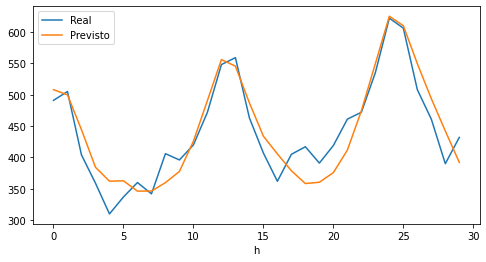

In [20]:
testex2 = testex.copy() #AJEITAR ISSO AQUI PQ N TA PEGANDO O ÚLTIMO ÍNDICE
for i in range(len(testey)-1):
  if i == 0:
    ypred = model.predict(testex2[0].reshape(1,k,1)).reshape(1,)
    testex2[1] = np.append(testex2[0, 1:k], ypred).reshape(k,1)
  else:
    ypred = np.append(ypred, model.predict(testex2[i].reshape(1,k,1)).reshape(1,))  
    testex2[i+1] = np.append(testex2[i, 1:k], ypred[i]).reshape(k,1)

ypred = np.append(ypred, model.predict(testex2[-1].reshape(1,k,1)).reshape(1,))  


preds_original = scaler.inverse_transform(ypred.reshape((-1,1)))

y_original = scaler.inverse_transform(testey)

mape = np.mean(abs((y_original - preds_original)/abs(y_original))*100)
mae = np.mean(abs(y_original - preds_original))
mse = np.mean((y_original - preds_original)**2)

print("MAPE: " + str(round(mape,3)) + "%")
print("MAE: " + str(round(mae,3)))
print("MSE: " + str(round(mse,3)))
print("Vício: {}".format(np.mean(preds_original - y_original).round(3)))


plt.figure(figsize = (8, 4))
plt.plot(y_original)
plt.plot(preds_original)
plt.legend(("Real", "Previsto"))
plt.xlabel("h")